In [1]:
import torch
from utils.dataset_utils import load_dataset, load_dataset_with_pairs
from tda.compute import analyze_and_plot_tda
# json_file = "/home/muzammal/Projects/safe_proj/long_safe_clip/dataset/visu/ViSU-Text_test.json"
# safe_img_dir = "/home/muzammal/Projects/safe_proj/long_safe_clip/dataset/visu/image/test_coco"
# nsfw_image_dir = "/home/muzammal/Projects/safe_proj/long_safe_clip/dataset/visu/image/test_nsfw_flux_sldr"
json_file = r"H:\ProjectsPro\safe_tda\data\dataset\ViSU-Text_train_5K.json"
safe_img_dir = r"H:\ProjectsPro\safe_tda\data\dataset\train_coco_5k"
nsfw_image_dir = r"H:\ProjectsPro\safe_tda\data\dataset\train_FLUX_Unsensored_5k"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
# Load data
print("Loading dataset...")
safe_texts, safe_image_paths, nsfw_texts, nsfw_image_paths = load_dataset(json_file, safe_img_dir, nsfw_image_dir)
# Load paired data for NSFW evaluations
# print("Loading paired dataset...")
# pairs, all_texts, all_image_paths = load_dataset_with_pairs(json_file, safe_img_dir, nsfw_image_dir)

D:\Anaconda\envs\pytorch\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda\envs\pytorch\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
D:\Anaconda\envs\pytorch\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


Using device: cuda
Loading dataset...
Loading dataset...
Loaded 5000 safe texts and 5000 NSFW texts
Loaded 0 safe images and 5000 NSFW images


In [12]:
from utils.model_utils import load_clip
from utils.dataset_utils import extract_text_embeddings, extract_image_embeddings

model_name = "ViT-L/14"  # or "longclip"
clip_model, clip_preprocess, clip_tokenizer = load_clip(model_name, device)
print("-" * 30)

# --- Option A: Analyze Text Embeddings ---
print("Extracting safe TEXT embeddings...")
safe_text_embeddings = extract_text_embeddings(safe_texts, clip_model, clip_tokenizer, device, batch_size=64)
print("Extracting nsfw TEXT embeddings...")
nsfw_text_embeddings = extract_text_embeddings(nsfw_texts, clip_model, clip_tokenizer, device, batch_size=64)
analysis_label = "Text"
# --- Option B: Analyze Image Embeddings ---
# print("Extracting safe IMAGE embeddings...")
# safe_image_embeddings = extract_image_embeddings(safe_image_paths, clip_model, clip_preprocess, device, BATCH_SIZE_IMAGE)
# print("Extracting nsfw IMAGE embeddings...")
# nsfw_image_embeddings = extract_image_embeddings(nsfw_image_paths, clip_model, clip_preprocess, device, BATCH_SIZE_IMAGE)
# analysis_label = "Image"

Loading CLIP model...
------------------------------
Extracting safe TEXT embeddings...


Extracting text features: 100%|██████████| 79/79 [00:02<00:00, 30.26it/s]


text_features shape: torch.Size([5000, 768])
Extracting nsfw TEXT embeddings...


Extracting text features: 100%|██████████| 79/79 [00:02<00:00, 29.62it/s]

text_features shape: torch.Size([5000, 768])



--- Analyzing SAFE Text Embeddings (50 samples) ---
Computing persistence...
Finished computing persistence.

--- Persistence Intervals for Dim 3 (Unsafe Text) ---
No Betti 3 features found in persistence intervals.

Plotting SAFE Text results...


D:\Anaconda\envs\pytorch\lib\site-packages\gudhi\persistence_graphical_tools.py:129: UserWarning: usetex mode requires TeX.
  warnings.warn("usetex mode requires TeX.")


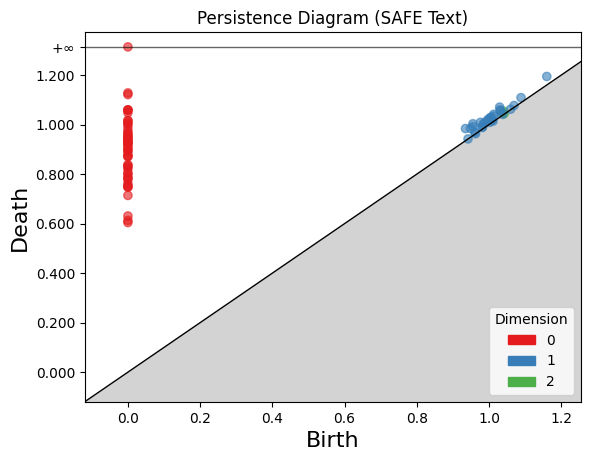

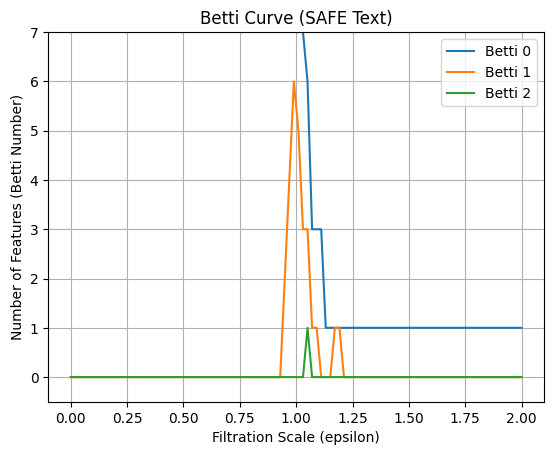


--- Analyzing nsfw Text Embeddings (50 samples) ---
Computing persistence...
Finished computing persistence.

--- Persistence Intervals for Dim 3 (Unsafe Text) ---
No Betti 3 features found in persistence intervals.

Plotting nsfw Text results...


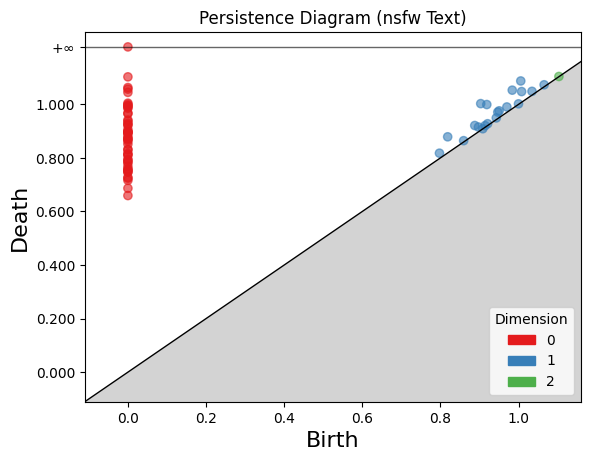

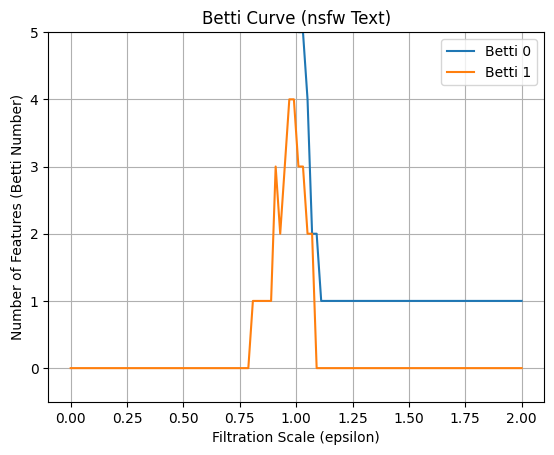

In [13]:
x = 1100
persistence_safe, betti_safe = analyze_and_plot_tda(safe_text_embeddings[x:x+50], f"SAFE {analysis_label}",complex='rips',max_filt_scale=2,max_hom_dim=5,threshold_count=100)
persistence_nsfw, betti_nsfw = analyze_and_plot_tda(nsfw_text_embeddings[x:x+50], f"nsfw {analysis_label}",complex='rips',max_filt_scale=2,max_hom_dim=5,threshold_count=100)

In [14]:
from tda.vectorize import vectorize_landscape, vectorize_persistence_image, vectorize_betti_curve, vectorize_simple_stats
import numpy as np
print("\n--- Vectorizing Features ---")

MAX_FILTRATION_SCALE = 2.0  # Adjust this based on your data
# --- Safe Data ---
# Persistence Landscape (H1, 3 landscapes, 100 samples between scale 0 and 1.5)
landscape_vec_safe = vectorize_landscape(persistence_safe, num_landscapes=3, resolution=100, x_min=0.0, x_max=MAX_FILTRATION_SCALE) 
# Persistence Image (H1, default params, 20x20 resolution)
image_vec_safe = vectorize_persistence_image(persistence_safe, resolution=[20, 20]) 
# Betti Curve Vector (sampling at 50 points)
betti_vec_safe = vectorize_betti_curve(betti_safe, num_samples=50, sample_scales=np.linspace(0, MAX_FILTRATION_SCALE, 50)) 
# Simple Stats (H0, H1)
stats_vec_safe = vectorize_simple_stats(persistence_safe, max_dim=1) 

print("Safe Vector Lengths:")
print(f"  Landscape (H1): {landscape_vec_safe.shape}")
print(f"  Image (H1): {image_vec_safe.shape}")
print(f"  Betti Curve: {betti_vec_safe.shape}")
print(f"  Simple Stats (H0, H1): {stats_vec_safe.shape}")


# --- nsfw Data (similar calls) ---
landscape_vec_nsfw = vectorize_landscape(persistence_nsfw, num_landscapes=3, resolution=100, x_min=0.0, x_max=MAX_FILTRATION_SCALE)
image_vec_nsfw = vectorize_persistence_image(persistence_nsfw, resolution=[20, 20])
betti_vec_nsfw = vectorize_betti_curve(betti_nsfw, num_samples=50, sample_scales=np.linspace(0, MAX_FILTRATION_SCALE, 50))
stats_vec_nsfw = vectorize_simple_stats(persistence_nsfw, max_dim=1)

print("\nnsfw Vector Lengths:")
print(f"  Landscape (H1): {landscape_vec_nsfw.shape}")
print(f"  Image (H1): {image_vec_nsfw.shape}")
print(f"  Betti Curve: {betti_vec_nsfw.shape}")
print(f"  Simple Stats (H0, H1): {stats_vec_nsfw.shape}")

# --- Now you can use these vectors (e.g., landscape_vec_safe, image_vec_nsfw) ---
# --- as input features for machine learning models ---


--- Vectorizing Features ---
Safe Vector Lengths:
  Landscape (H1): (300,)
  Image (H1): (400,)
  Betti Curve: (150,)
  Simple Stats (H0, H1): (16,)

nsfw Vector Lengths:
  Landscape (H1): (300,)
  Image (H1): (400,)
  Betti Curve: (150,)
  Simple Stats (H0, H1): (16,)
